# **Pre-Requisites**

In [1]:
# Load the required modules

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,GRU, Dense, Bidirectional
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.layers import TimeDistributed, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [2]:
# Load the dataset

df = pd.read_csv('electricityConsumptionAndProductioction.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.head()

,DateTime,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
1,2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2,2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
3,2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
4,2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30


# **Data Visualisation and EDA**

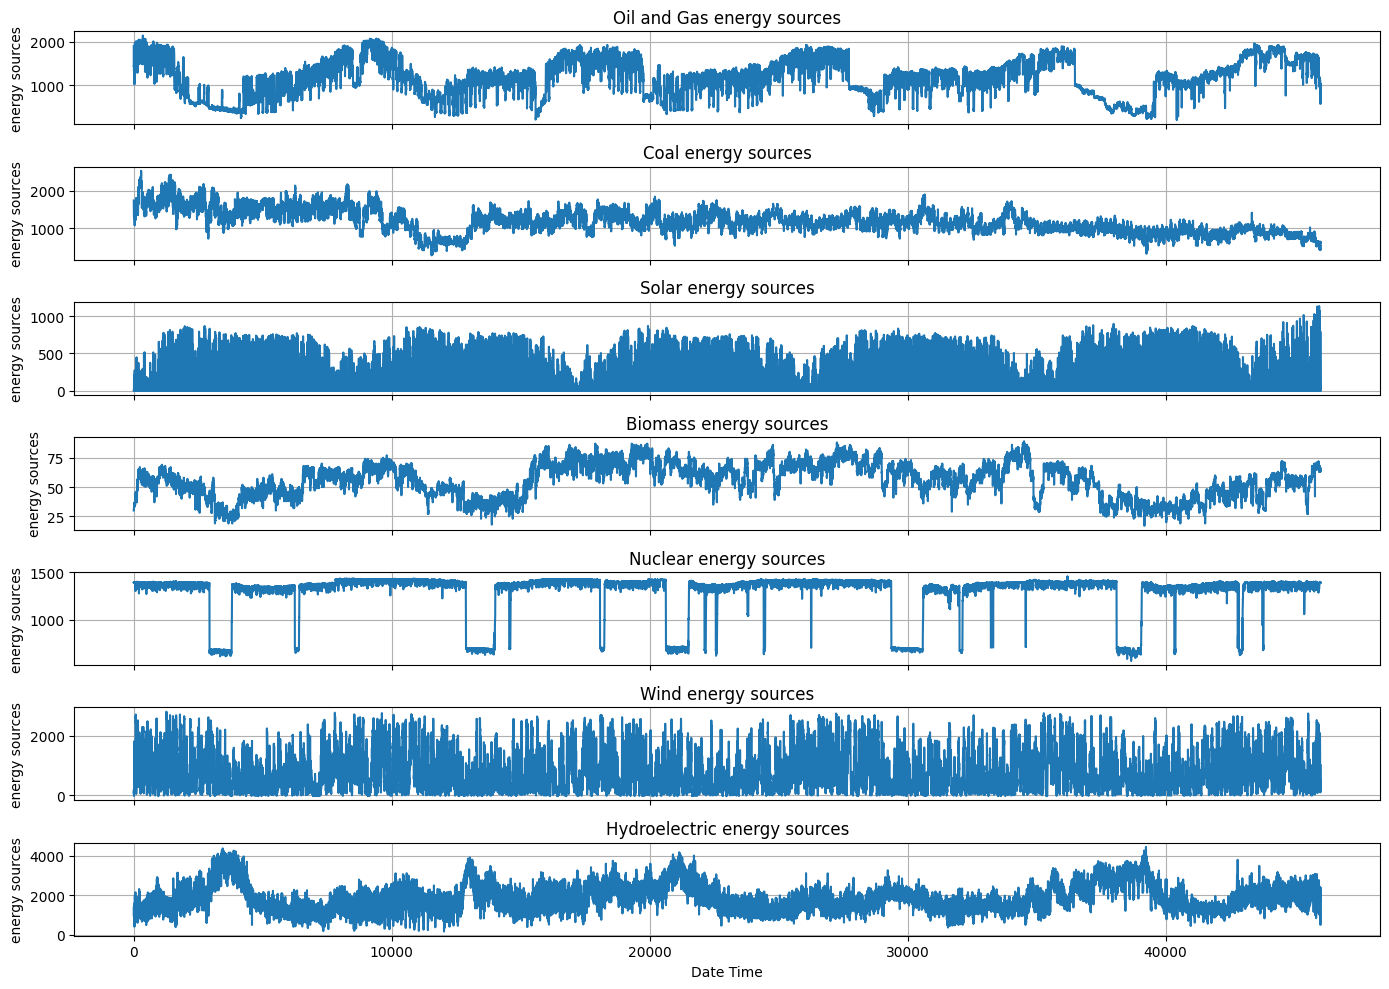

In [3]:
# Plot of Energy sources v/s Date-Time

energy_sources = ['Oil and Gas', 'Coal', 'Solar', 'Biomass', 'Nuclear',	'Wind',	'Hydroelectric']
fig, axes = plt.subplots(nrows=len(energy_sources), ncols=1, figsize=(14, 10), sharex=True)
for i, source in enumerate(energy_sources):
    axes[i].plot(df.index, df[source], label=source)
    axes[i].set_ylabel('energy sources')
    axes[i].set_title(f'{source} energy sources')
    axes[i].grid(True)
plt.xlabel('Date Time')
plt.tight_layout()
plt.show()

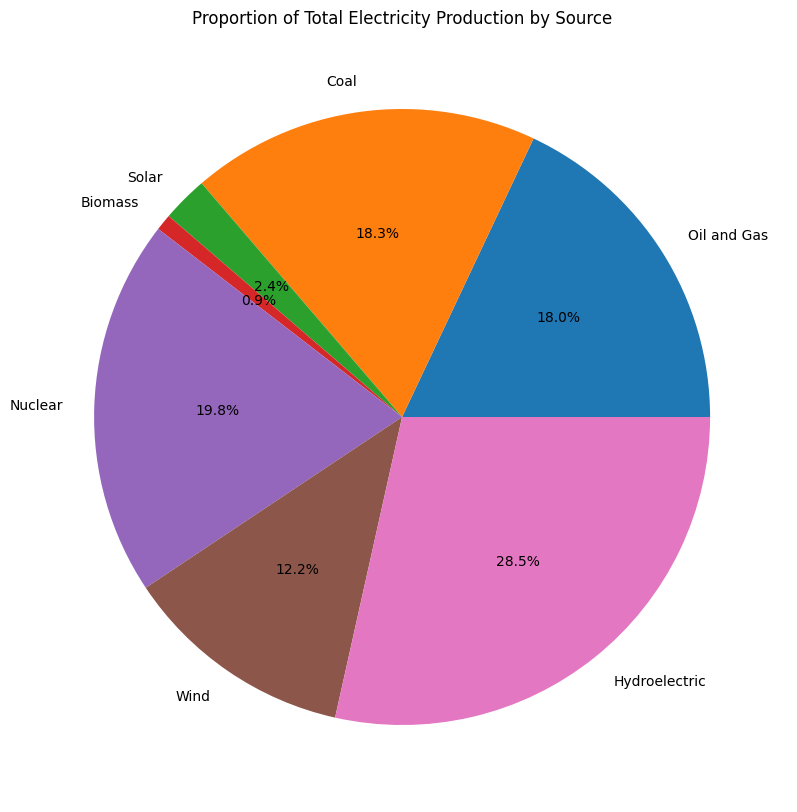

In [4]:
# Proportion of electricity produced by each source

total_production_by_source = df[energy_sources].sum()
plt.figure(figsize=(10, 10))
total_production_by_source.plot(kind='pie', autopct='%1.1f%%')
plt.ylabel('')
plt.title('Proportion of Total Electricity Production by Source')
plt.show()

**Inference:** The dataset is a bit skewed because hydroelectric electricity is not the most common source of electricity production. It is Coal and Oil and Gas.

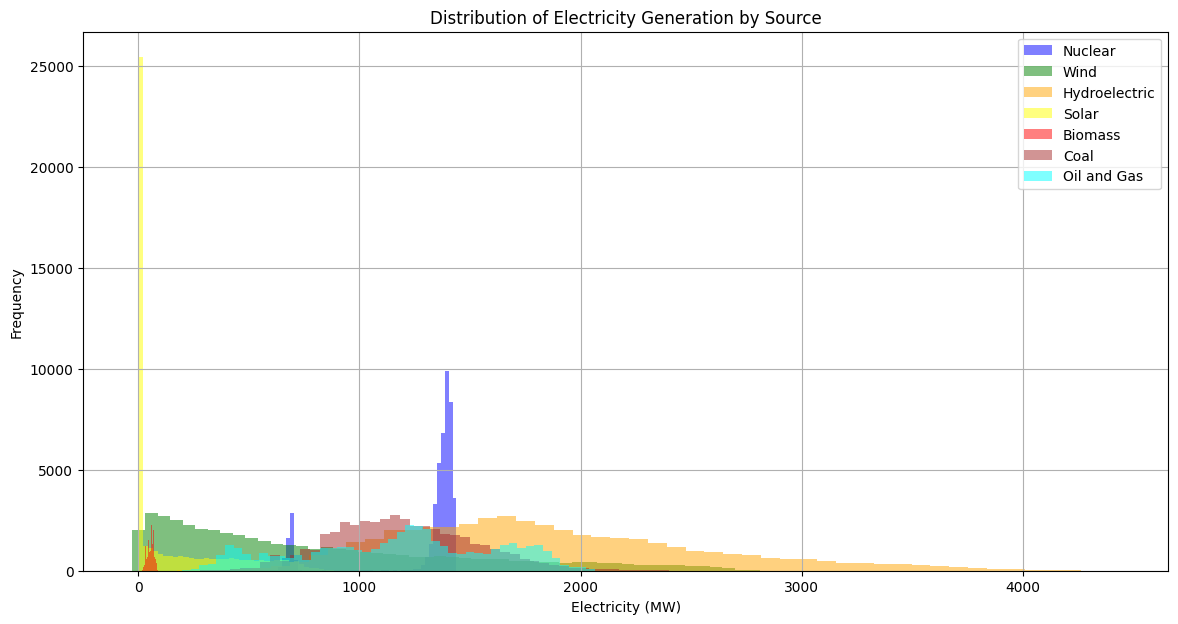

In [5]:
# Distribution of electricity generation from different sources

plt.figure(figsize=(14, 7))
plt.hist(df['Nuclear'], bins=50, alpha=0.5, label='Nuclear', color='blue')
plt.hist(df['Wind'], bins=50, alpha=0.5, label='Wind', color='green')
plt.hist(df['Hydroelectric'], bins=50, alpha=0.5, label='Hydroelectric', color='orange')
plt.hist(df['Solar'], bins=50, alpha=0.5, label='Solar', color='yellow')
plt.hist(df['Biomass'], bins=50, alpha=0.5, label='Biomass', color='red')
plt.hist(df['Coal'], bins=50, alpha=0.5, label='Coal', color='brown')
plt.hist(df['Oil and Gas'], bins=50, alpha=0.5, label='Oil and Gas', color='cyan')
plt.xlabel('Electricity (MW)')
plt.ylabel('Frequency')
plt.title('Distribution of Electricity Generation by Source')
plt.legend()
plt.grid(True)
plt.show()

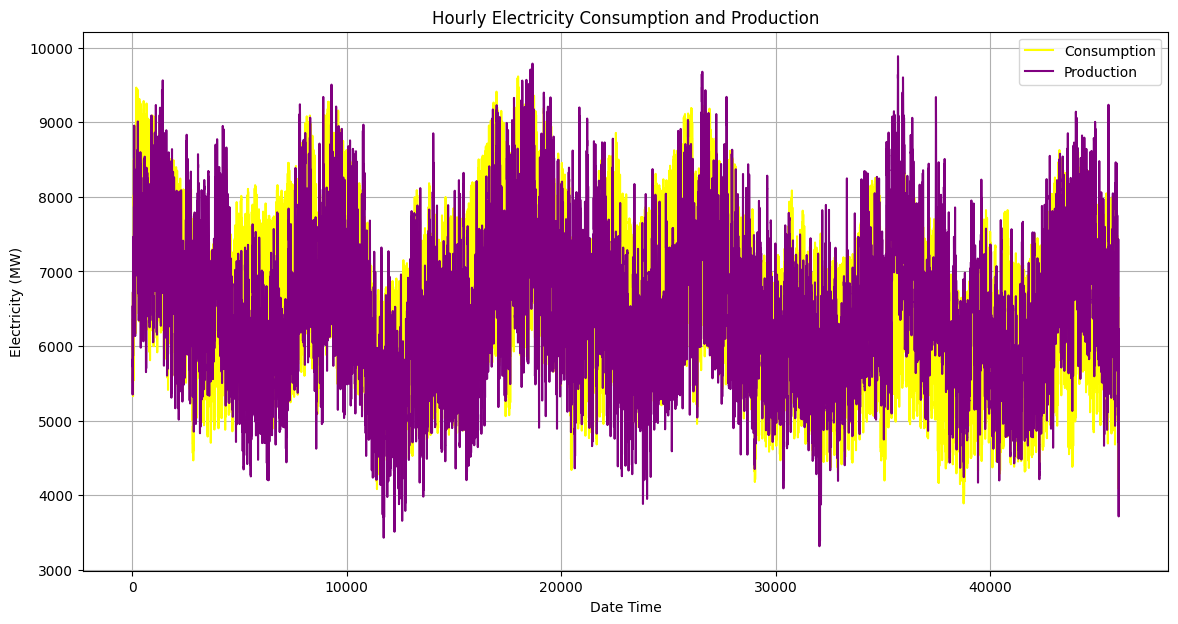

In [6]:
# Production v/s Consumption per hour

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Consumption'], label='Consumption', color='yellow')
plt.plot(df.index, df['Production'], label='Production', color='purple')
plt.xlabel('Date Time')
plt.ylabel('Electricity (MW)')
plt.title('Hourly Electricity Consumption and Production')
plt.legend()
plt.grid(True)
plt.show()

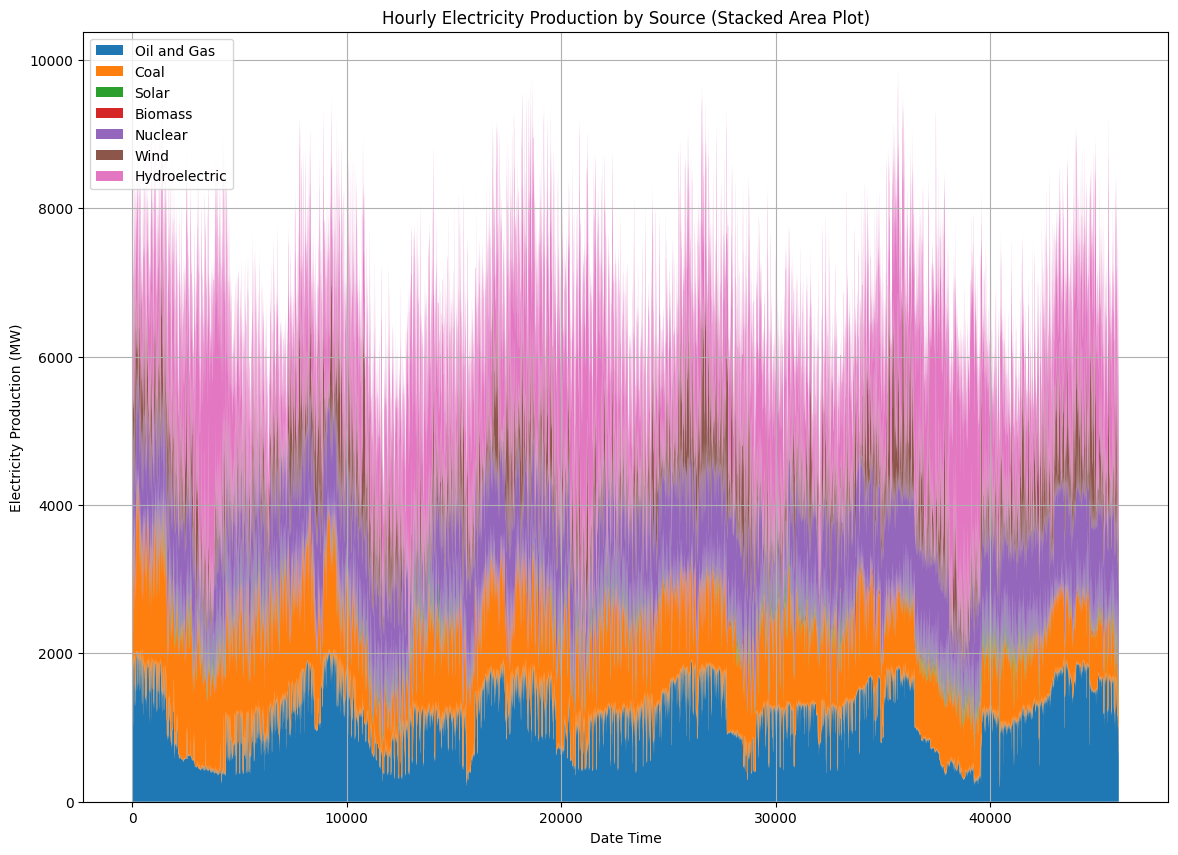

In [7]:
# Electricity produced by every soure

plt.figure(figsize=(14, 10))
plt.stackplot(df.index, [df[source] for source in energy_sources], labels=energy_sources)
plt.xlabel('Date Time')
plt.ylabel('Electricity Production (MW)')
plt.title('Hourly Electricity Production by Source (Stacked Area Plot)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

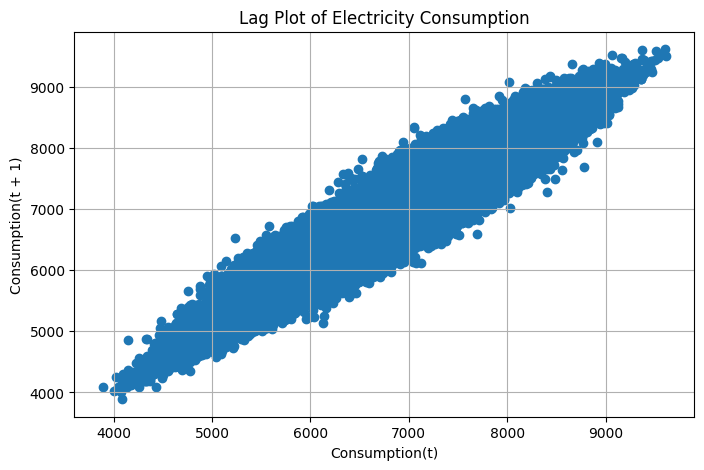

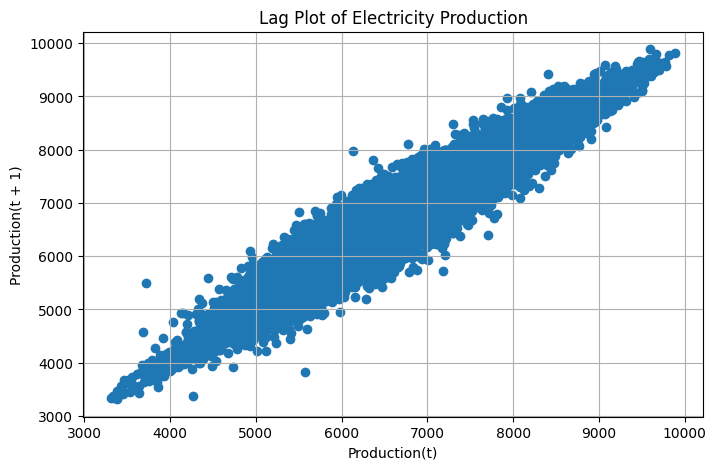

In [8]:
# Lagplot of consumption and production

plt.figure(figsize=(8, 5))
lag_plot(df['Consumption'])
plt.title('Lag Plot of Electricity Consumption')
plt.xlabel('Consumption(t)')
plt.ylabel('Consumption(t + 1)')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
lag_plot(df['Production'])
plt.title('Lag Plot of Electricity Production')
plt.xlabel('Production(t)')
plt.ylabel('Production(t + 1)')
plt.grid(True)
plt.show()

**Inference:** The amount of electricity produced and consumed during every unit of time almost aligns perfectly as predicted by their line graph.

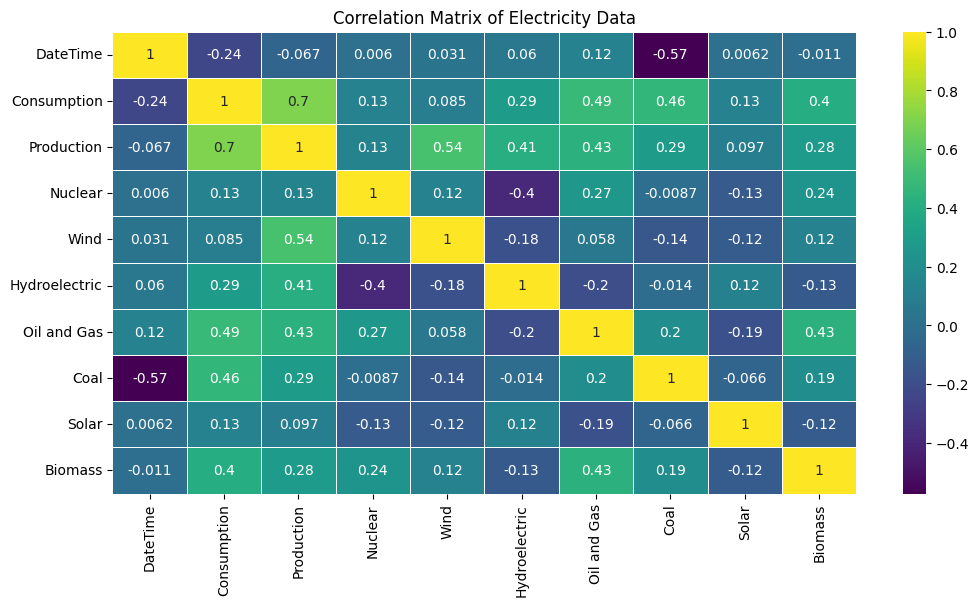

In [9]:
# Correlation matrix

plt.figure(figsize=(12, 6))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='viridis', linewidths=0.5)

plt.title('Correlation Matrix of Electricity Data')
plt.show()

**Inferences:**

* There is a high correlation between production and consumption, as should be.
* There is high correlation among consumption and coal, oil and gas.
* There is high correlation among Production and Hydroelectric, wind, oil and gas.

# **RNN-Based Time Series Forecasting of Electricity Consumption**

In [10]:
# Normalize the data

scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df[['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass']])
scaled_df = pd.DataFrame(scaled_df, columns=['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass'])
scaled_df.head()

,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,0.430143,0.488814,0.930726,0.037011,0.283635,0.873906,0.648804,0.0,0.180556
1,0.388928,0.363111,0.928492,0.043003,0.220005,0.633556,0.603189,0.0,0.180556
2,0.346490,0.359306,0.928492,0.059217,0.200751,0.652084,0.592117,0.0,0.180556
3,0.313133,0.348197,0.932961,0.076489,0.187133,0.646938,0.566430,0.0,0.180556
4,0.291303,0.325521,0.928492,0.065210,0.184316,0.646423,0.522143,0.0,0.180556


In [11]:
# Create sequences of 24 hours

def create_sequences(df, seq_length):
    sequences = []
    labels = []
    for i in range(len(df) - seq_length):
        seq = df.iloc[i:i+seq_length].values
        label = df['Consumption'].iloc[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

SEQ_LENGTH = 24
sequences, labels = create_sequences(scaled_df, SEQ_LENGTH)

In [12]:
# Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, shuffle=False)

In [13]:
# RNN Model Definition

rnn_model = Sequential([
    SimpleRNN(50, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
    SimpleRNN(50),
    Dense(1)
])
rnn_model.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
# Training and Evaluation

rnn_history = rnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)
rnn_predictions = rnn_model.predict(X_test)

Epoch 1/20
920/920 [==============================] - 45s 45ms/step - loss: 0.0082 - val_loss: 0.0020
Epoch 2/20
920/920 [==============================] - 41s 44ms/step - loss: 0.0014 - val_loss: 8.1416e-04
Epoch 3/20
920/920 [==============================] - 40s 44ms/step - loss: 0.0012 - val_loss: 8.7665e-04
Epoch 4/20
920/920 [==============================] - 40s 43ms/step - loss: 9.7454e-04 - val_loss: 6.2337e-04
Epoch 5/20
920/920 [==============================] - 40s 44ms/step - loss: 9.7442e-04 - val_loss: 6.3287e-04
Epoch 6/20
920/920 [==============================] - 40s 44ms/step - loss: 9.1534e-04 - val_loss: 6.0707e-04
Epoch 7/20
920/920 [==============================] - 39s 43ms/step - loss: 8.0560e-04 - val_loss: 0.0014
Epoch 8/20
920/920 [==============================] - 40s 44ms/step - loss: 7.7850e-04 - val_loss: 0.0010
Epoch 9/20
920/920 [==============================] - 38s 42ms/step - loss: 7.3820e-04 - val_loss: 5.4318e-04
Epoch 10/20
920/920 [=============

In [15]:
# Evaluation metrics for RNN

rnn_r2 = r2_score(y_test, rnn_predictions)
rnn_mae = mean_absolute_error(y_test, rnn_predictions)
rnn_mse = mean_squared_error(y_test, rnn_predictions)
rnn_rmse = np.sqrt(rnn_mse)
print(f'RNN - R² Score: {rnn_r2}')
print(f'RNN - Mean Absolute Error (MAE): {rnn_mae}')
print(f'RNN - Mean Squared Error (MSE): {rnn_mse}')
print(f'RNN - Root Mean Squared Error (RMSE): {rnn_rmse}')

RNN - R² Score: 0.9782967125409907
RNN - Mean Absolute Error (MAE): 0.01874504520606739
RNN - Mean Squared Error (MSE): 0.0005797661673660227
RNN - Root Mean Squared Error (RMSE): 0.02407833398235897


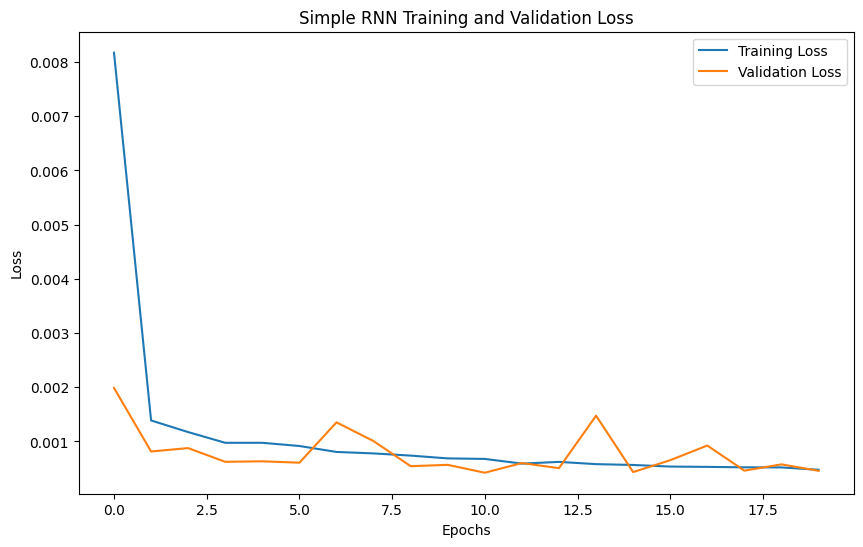

In [16]:
# Plotting loss function

plt.figure(figsize=(10,6))
plt.plot(rnn_history.history['loss'], label='Training Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('Simple RNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

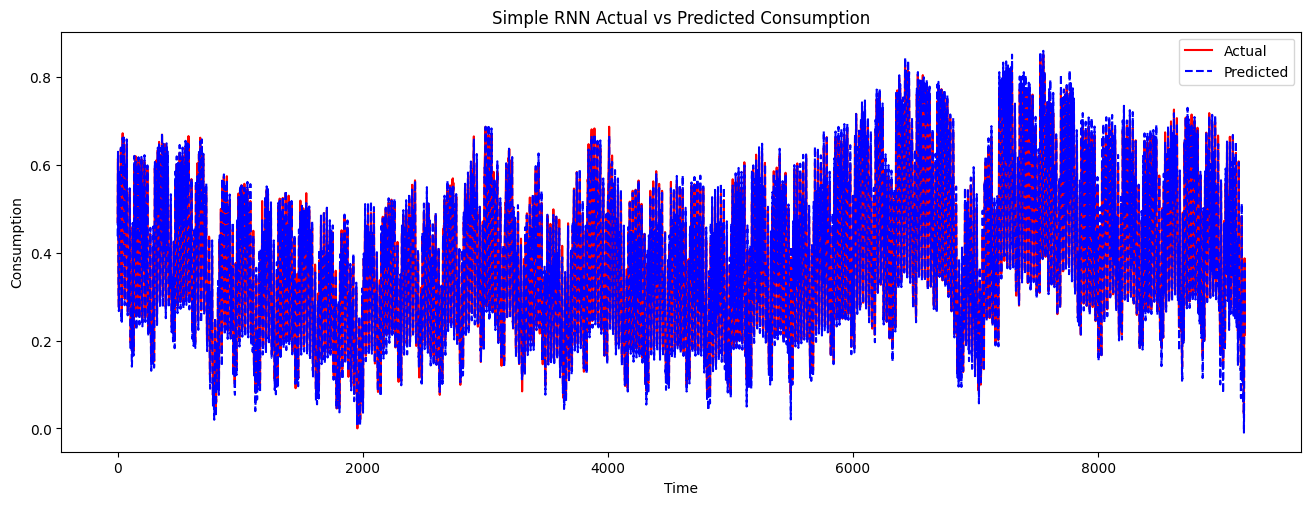

In [17]:
# Actual Vs Predicted Consumption

plt.figure(figsize=(16, 12))
plt.subplot(2, 1, 1)
plt.plot(y_test, label='Actual', color='red')
plt.plot(rnn_predictions, label='Predicted', color='blue', linestyle='dashed')
plt.title('Simple RNN Actual vs Predicted Consumption')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.legend()

**Inference:** Despite seeming like the model might overfit (from the loss while training), there is a pretty good overlap and our model did well.

# **LSTM-Based Time Series Forecasting of Electricity Consumption**

In [18]:
# Feature Engineering and normalisaztion

df['hour'] = pd.to_datetime(df['DateTime']).dt.hour
df['dayofweek'] = pd.to_datetime(df['DateTime']).dt.dayofweek
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df[['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass', 'hour', 'dayofweek']])
scaled_df = pd.DataFrame(scaled_df, columns=['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass', 'hour', 'dayofweek'])

In [19]:
# Create sequences of 24 hours

def create_sequences(df, seq_length):
    sequences = []
    labels = []
    for i in range(len(df) - seq_length):
        seq = df.iloc[i:i+seq_length].values
        label = df['Consumption'].iloc[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

SEQ_LENGTH = 24
sequences, labels = create_sequences(scaled_df, SEQ_LENGTH)

In [20]:
# Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, shuffle=False)

In [21]:
# LSTM Model Definition

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

In [22]:
# Training and Evaluation

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)
predictions = model.predict(X_test)

Epoch 1/20
920/920 [==============================] - 12s 8ms/step - loss: 0.0106 - val_loss: 0.0034
Epoch 2/20
920/920 [==============================] - 7s 8ms/step - loss: 0.0039 - val_loss: 0.0018
Epoch 3/20
920/920 [==============================] - 6s 7ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 4/20
920/920 [==============================] - 7s 7ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 5/20
920/920 [==============================] - 8s 8ms/step - loss: 0.0018 - val_loss: 9.5597e-04
Epoch 6/20
920/920 [==============================] - 6s 7ms/step - loss: 0.0014 - val_loss: 7.7425e-04
Epoch 7/20
920/920 [==============================] - 8s 9ms/step - loss: 0.0012 - val_loss: 6.5867e-04
Epoch 8/20
920/920 [==============================] - 7s 7ms/step - loss: 0.0011 - val_loss: 6.4371e-04
Epoch 9/20
920/920 [==============================] - 7s 8ms/step - loss: 9.6122e-04 - val_loss: 5.5080e-04
Epoch 10/20
920/920 [==============================] - 7s 7ms/step - loss: 

In [23]:
# Evaluation metrics for LSTM

r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f'R² Score: {r2}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

R² Score: 0.978383147803779
Mean Absolute Error (MAE): 0.018861652783675232
Mean Squared Error (MSE): 0.0005774571973020764
Root Mean Squared Error (RMSE): 0.024030339100854912


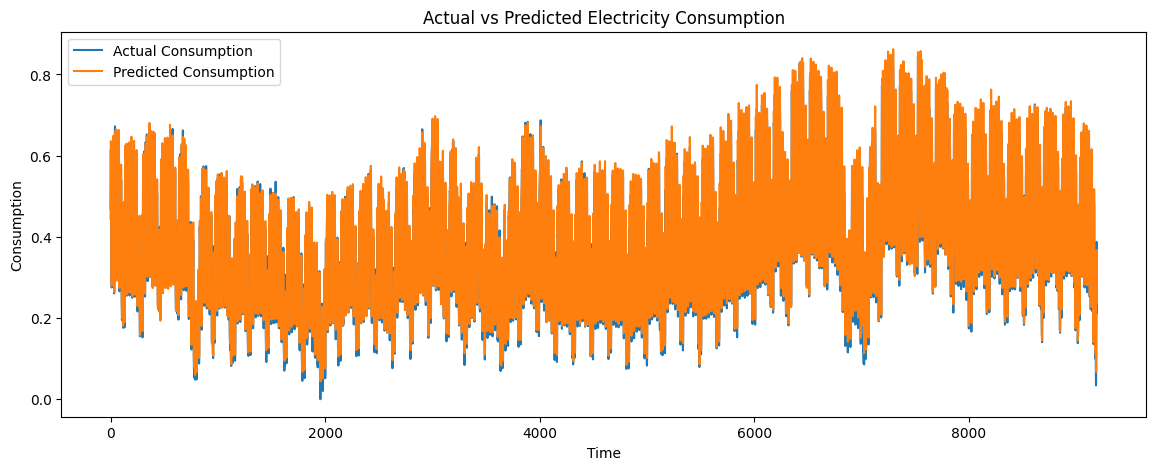

In [24]:
# Plot predictions vs actual values

plt.figure(figsize=(14, 5))
plt.plot(y_test, label='Actual Consumption')
plt.plot(predictions, label='Predicted Consumption')
plt.title('Actual vs Predicted Electricity Consumption')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.legend()
plt.show()

**Inference:** Despite seeming like the model might overfit (from the loss while training), there is a pretty good overlap and our model did well.

# **Conclusion:**
Both the models gave pretty good results but LSTM performed slightly better than RNN.

# For you to try:
1) Try using Gated Recurrent Units (GRUs).
2) Understand the differences between these 3 types of models.